# Court Detection

Reference: https://github.com/Jhuangsp/court_detection

In [726]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pprint

pp = pprint.PrettyPrinter(indent=4)

## Construct Background Model

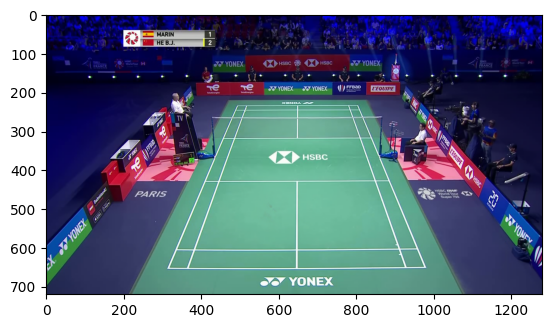

In [727]:
filename = "input.mp4"
folder = "result_" + filename.split(".")[0] + "/"

# Fix random seed
np.random.seed(0)

cap = cv2.VideoCapture(filename)

frames = []

# Randomly sample 50 frames
for i in range(50):
    cap.set(
        cv2.CAP_PROP_POS_FRAMES, np.random.randint(0, cap.get(cv2.CAP_PROP_FRAME_COUNT))
    )
    ret, frame = cap.read()
    frames.append(frame)

cap.release()

img = np.median(frames, axis=0).astype(np.uint8)

height, width = img.shape[:2]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Image Sharpening

In [728]:
if not os.path.isdir(folder):
    os.mkdir(folder)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

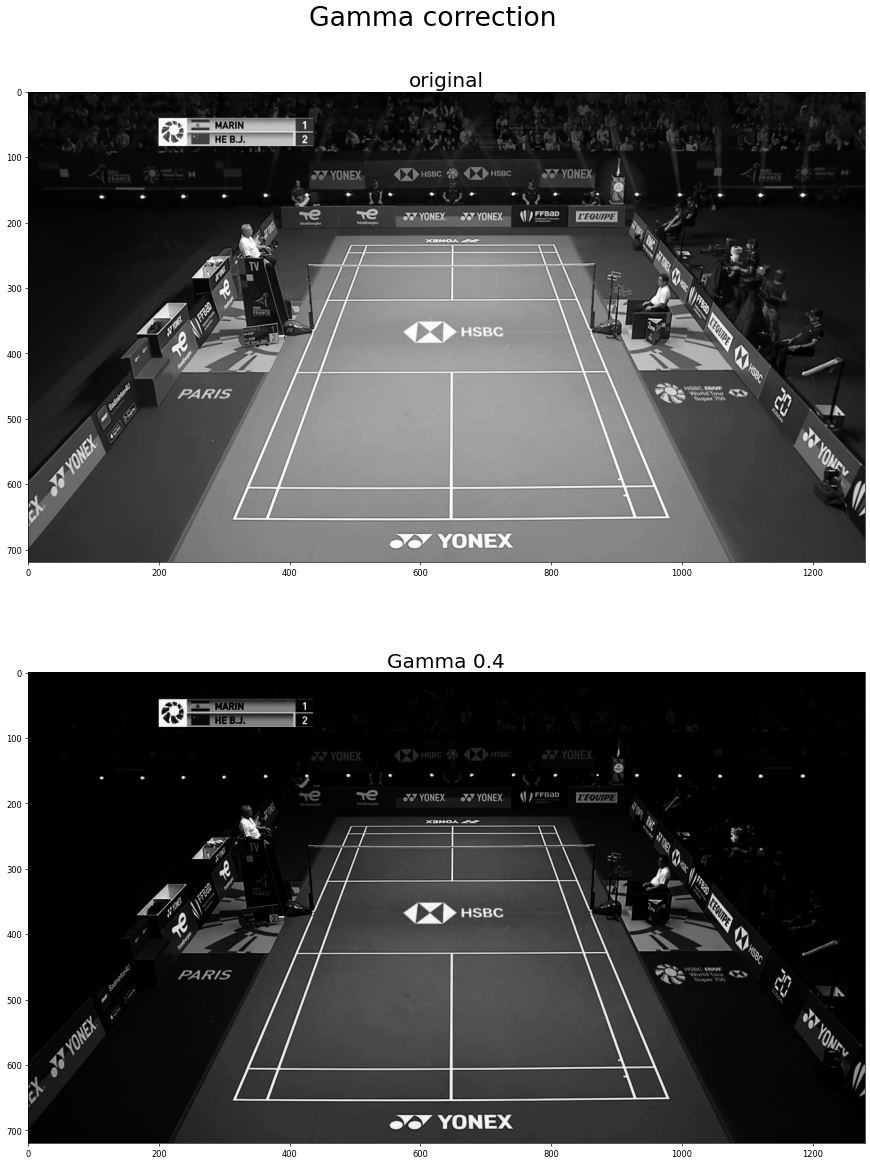

In [729]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array(
        [((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]
    ).astype("uint8")
    return cv2.LUT(image, table)  # apply gamma correction using the lookup table


gamma = 0.4
fig, axs = plt.subplots(2, 1, figsize=(18, 24), dpi=60)
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # 設定子圖的間隔
fig.suptitle("Gamma correction", y=0.92, fontsize=32)
g = adjust_gamma(gray, gamma)

axs[0].imshow(gray, cmap="gray")
axs[0].set_title("original", fontsize=24)
axs[1].imshow(g, cmap="gray")
axs[1].set_title("Gamma {}".format(gamma), fontsize=24)
plt.show()

## Find Court Region

[[[ 60 255 255]]]


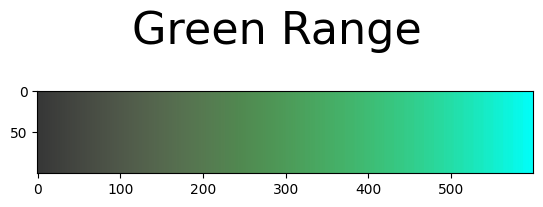

In [730]:
# generate green space
fig = plt.figure()
fig.suptitle("Green Range", y=0.75, fontsize=32)

green = np.uint8([[[0, 255, 0]]])
range1 = [20, 255, 200]
range2 = [30, 0, 0]
hsv_green = cv2.cvtColor(green, cv2.COLOR_BGR2HSV)
green_map = np.linspace(
    hsv_green.reshape(-1) - range1, hsv_green.reshape(-1) + range2, 600
)
green_map = np.tile(np.expand_dims(green_map, axis=0), (100, 1, 1))
print(hsv_green)
plt.imshow(cv2.cvtColor(green_map.astype(np.uint8), cv2.COLOR_HSV2RGB))
plt.show()

(720, 1280)


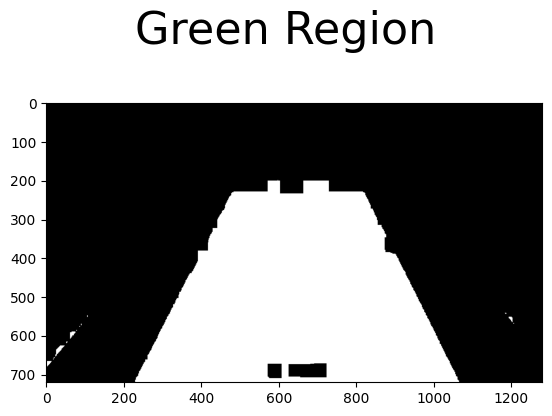

In [731]:
fig = plt.figure()
fig.suptitle("Green Region", fontsize=32)

# detect green region
iterations = 10
mask = cv2.inRange(hsv, hsv_green - range1, hsv_green + range2) > 0
print(mask.shape)
mask = cv2.erode(mask.astype(np.float32), None, iterations=3)
mask = cv2.dilate(mask.astype(np.float32), None, iterations=iterations)
mask = cv2.erode(mask, None, iterations=iterations + 5)
plt.imshow(mask, cmap="gray")
plt.show()
mask = mask > 0
mask = np.stack((mask, mask, mask), 2)

## Find Straight Lines

In [732]:
# line detect
kernel_size = 5

# sharpen
gray = adjust_gamma(gray, 0.4)
blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0).astype(int)
sub = gray.astype(int) - blur
sharped_img = np.clip(gray.astype(int) + sub * 2, a_min=0, a_max=255).astype("uint8")

# sharped_gray = cv2.cvtColor(sharped_img, cv2.COLOR_BGR2GRAY)
low_threshold = 85
high_threshold = 85 * 3
edges = cv2.Canny(sharped_img, low_threshold, high_threshold, apertureSize=3)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 30  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 75  # minimum number of pixels making up a line
max_line_gap = 5  # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(
    edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap
)

60 Lines


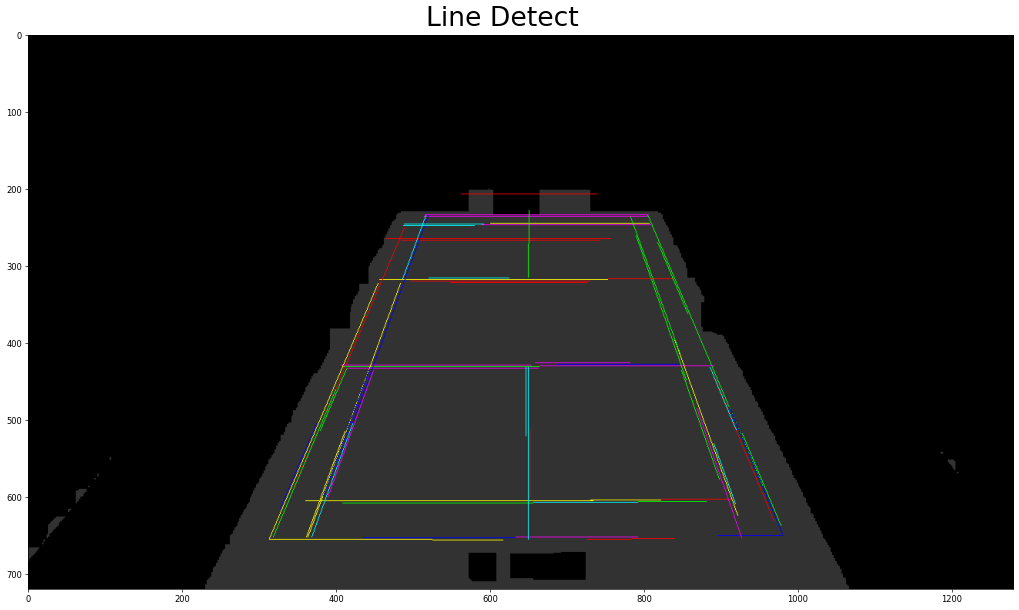

In [733]:
import random

fig = plt.figure(figsize=(24, 12), dpi=60)
fig.suptitle("Line Detect", y=0.92, fontsize=32)

m_lines = []


def interpolate(pt):
    x1, y1, x2, y2 = pt
    num = max(abs(x1 - x2), abs(y1 - y2))
    np.around(np.linspace(x1, x2 + 1, num=num + 1))
    return np.stack(
        (
            np.around(np.linspace(x1, x2, num=num + 1)),
            np.around(np.linspace(y1, y2, num=num + 1)),
        ),
        axis=1,
    ).astype(int)


# filter out lines
for line in lines.reshape(-1, 4):
    # interpolate
    full_line = interpolate(line)
    check = mask[:, :, 0][full_line[:, 1], full_line[:, 0]]
    if check.sum() >= len(check) * 0.5:
        m_lines.append(line)

print(len(m_lines), "Lines")
tmp = np.zeros_like(img) + mask.astype("uint8") * 50
for x1, y1, x2, y2 in m_lines:
    color = random.choice(
        [
            (0, 0, 255),
            (0, 255, 0),
            (255, 0, 0),
            (0, 255, 255),
            (255, 255, 0),
            (255, 0, 255),
        ]
    )
    cv2.line(tmp, (x1, y1), (x2, y2), color, 1)

plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))
plt.show()

## Extend straight line

/tmp/ipykernel_2364670/2739357539.py:53: RuntimeWarning: overflow encountered in ubyte_scalars
  and ggray[i, j] - ggray[i, j + dist_tau] > intensity_threshold
/tmp/ipykernel_2364670/2739357539.py:52: RuntimeWarning: overflow encountered in ubyte_scalars
  and ggray[i, j] - ggray[i, j - dist_tau] > intensity_threshold
/tmp/ipykernel_2364670/2739357539.py:62: RuntimeWarning: overflow encountered in ubyte_scalars
  and ggray[i, j] - ggray[i + dist_tau, j] > intensity_threshold
/tmp/ipykernel_2364670/2739357539.py:61: RuntimeWarning: overflow encountered in ubyte_scalars
  and ggray[i, j] - ggray[i - dist_tau, j] > intensity_threshold


{0, 1, 2, 3, 4, 5}
slopes: [[0, 2.743941016933837], [1, 2.743941016933837], [2, 2.740399572697584], [3, 2.745123848698041], [4, 2.743941016933837], [5, 2.740399572697584]]
newset: [[0, 2.743941016933837], [1, 2.743941016933837], [2, 2.740399572697584], [3, 2.745123848698041], [4, 2.743941016933837], [5, 2.740399572697584]]
{8, 11, 6}
slopes: [[8, 2.806963708596021], [11, 2.806963708596021], [6, 2.8094474631891178]]
newset: [[8, 2.806963708596021], [11, 2.806963708596021], [6, 2.8094474631891178]]
{9, 10, 7}
slopes: [[9, 2.79584008689815], [10, 2.794609557364406], [7, 2.7970717082993413]]
newset: [[9, 2.79584008689815], [10, 2.794609557364406], [7, 2.7970717082993413]]
{12, 13, 14, 15}
slopes: [[12, 0.011126105549387866], [13, 3.141591653589793], [14, 3.141591653589793], [15, 3.141591653589793]]
newset: [[12, 0.011126105549387866], [13, 3.141591653589793], [14, 3.141591653589793], [15, 3.141591653589793]]
{16, 17, 18, 19, 20, 21, 22}
slopes: [[16, 0.3494408706267289], [17, 0.34452094529

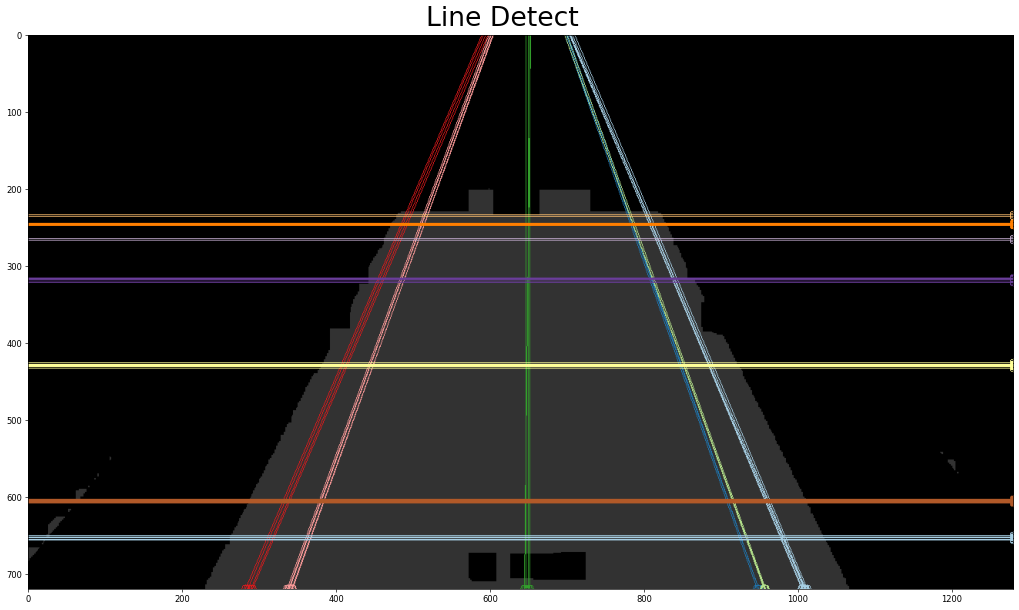

In [734]:
from utils import (
    merge_lines,
    lines_clustering,
    find_edge,
    find_intersection,
    parse_color,
    filter_set,
    check_white,
)
from math import sqrt
import colorbrewer

_h, _w, _ = img.shape
e_m_lines = []
for x1, y1, x2, y2 in m_lines:
    (e_x1, e_y1), (e_x2, e_y2) = find_edge(
        np.array([x1, y1]), np.array([x2, y2]), _h, _w
    )
    e_m_lines.append(np.array([e_x1, e_y1, e_x2, e_y2]))
e_m_lines.sort(key=lambda ele: ele[1])
idx_non_0 = next(
    (
        index
        for index, value in enumerate(np.array(e_m_lines)[:, 1].tolist())
        if value != 0
    ),
    None,
)
idx_is__h = next(
    (
        index
        for index, value in enumerate(np.array(e_m_lines)[:, 1].tolist())
        if value == _h - 1
    ),
    None,
)
e_m_lines[:idx_non_0] = sorted(e_m_lines[:idx_non_0], key=lambda ele: -ele[0])
if idx_is__h != None:
    e_m_lines[idx_is__h:] = sorted(e_m_lines[idx_is__h:], key=lambda ele: ele[0])

ggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

dist_tau = 3
intensity_threshold = 40

white_region = np.zeros_like(ggray)

for i in range(len(ggray)):
    for j in range(dist_tau, len(ggray[0]) - dist_tau):
        if (
            ggray[i, j] > 180
            and ggray[i, j] - ggray[i, j - dist_tau] > intensity_threshold
            and ggray[i, j] - ggray[i, j + dist_tau] > intensity_threshold
        ):
            white_region[i, j] = 255

for i in range(dist_tau, len(ggray) - dist_tau):
    for j in range(len(ggray[0])):
        if (
            ggray[i, j] > 180
            and ggray[i, j] - ggray[i - dist_tau, j] > intensity_threshold
            and ggray[i, j] - ggray[i + dist_tau, j] > intensity_threshold
        ):
            white_region[i, j] = 255

e_m_lines = merge_lines(e_m_lines)
# only keep the set that has more than one line
line_set = [
    i
    for i in lines_clustering(e_m_lines, threshold=8)
    if len(i) > 1 and check_white(hsv, e_m_lines, i, white_region)
]
print(len(line_set))

fig = plt.figure(figsize=(24, 12), dpi=60)
fig.suptitle("Line Detect", y=0.92, fontsize=32)

colors = colorbrewer.qualitative["Paired"][min(len(line_set), 12)]
tmp_2 = np.zeros_like(img) + mask.astype("uint8") * 50
for sid, l_set in enumerate(line_set):
    for line_id in l_set:
        x1, y1, x2, y2 = e_m_lines[line_id]
        try:
            color = parse_color(colors[sid % 12])
        except IndexError:
            color = (255, 255, 255)
        cv2.line(tmp_2, (x1, y1), (x2, y2), color, 1)
        cv2.circle(tmp_2, (x2, y2), 5, color)
    cv2.imwrite(folder + "colorful_set{}.png".format(sid), tmp_2)
cv2.imwrite(folder + "colorful.png", tmp_2)

fake_sets = filter_set(e_m_lines, line_set, _h, _w)
tmp_2_f = np.zeros_like(img) + mask.astype("uint8") * 50
for sid, l_set in enumerate(fake_sets):
    for x1, y1, x2, y2 in l_set:
        try:
            color = parse_color(colors[sid % 12])
        except IndexError:
            color = (255, 255, 255)
        cv2.line(tmp_2_f, (x1, y1), (x2, y2), color, 1)

    cv2.imwrite(folder + "colorful_fake_set{}.png".format(sid), tmp_2_f)
cv2.imwrite(folder + "colorful_f.png", tmp_2_f)

plt.imshow(cv2.cvtColor(tmp_2, cv2.COLOR_BGR2RGB))
plt.show()

In [735]:
# Classify lines into horizontal and vertical

lines = [sublist[0] for sublist in fake_sets]

h_lines = []
v_lines = []

for i, line in enumerate(lines):
    x1, y1, x2, y2 = line
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    if dx > 2 * dy:
        h_lines.append(i)
    else:
        v_lines.append(i)

left_v_lines = []
right_v_lines = []

left_th = width / 3
right_th = width * 2 / 3

for i in v_lines:
    x1, y1, x2, y2 = lines[i]
    if x1 < left_th or x2 < left_th:
        left_v_lines.append(i)
    elif x1 > right_th or x2 > right_th:
        right_v_lines.append(i)

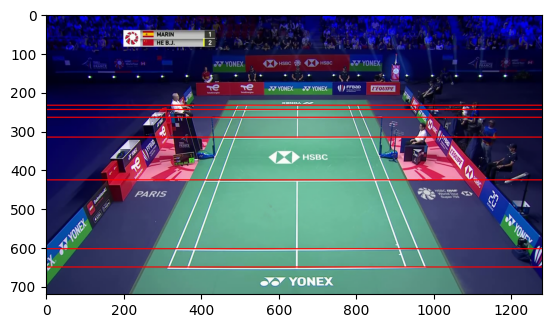

In [736]:
# Plot horizontal lines
tmp_3 = img.copy()

for i in h_lines:
    x1, y1, x2, y2 = lines[i]
    cv2.line(tmp_3, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(tmp_3, cv2.COLOR_BGR2RGB))

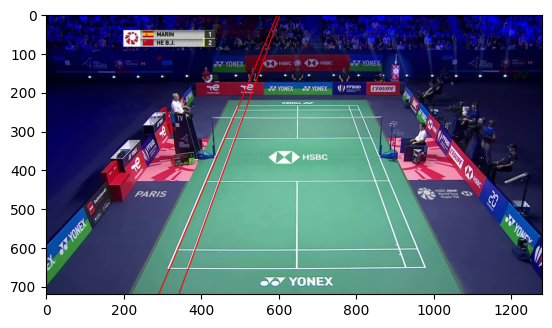

In [737]:
# Plot left vertical lines
tmp_3 = img.copy()

for i in left_v_lines:
    x1, y1, x2, y2 = lines[i]
    cv2.line(tmp_3, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(tmp_3, cv2.COLOR_BGR2RGB))

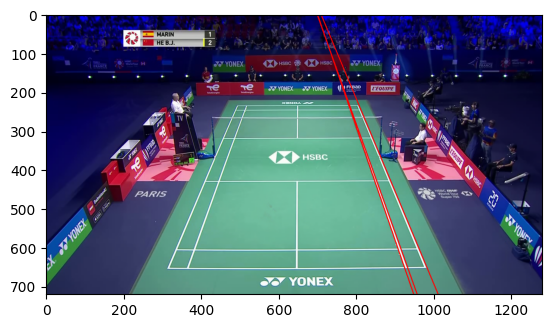

In [738]:
# Plot right vertical lines
tmp_3 = img.copy()

for i in right_v_lines:
    x1, y1, x2, y2 = lines[i]
    cv2.line(tmp_3, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(tmp_3, cv2.COLOR_BGR2RGB))

## Find Court Corners

new winner:
(6, 7) (4, 0) count 3456/3516, 98.29, good
(6, 7) (4, 1) count 3132/3192, 98.12, good
(6, 7) (4, 2) count 3156/3216, 98.13, good
new winner:
(6, 7) (5, 0) count 3726/3786, 98.42, good
(6, 7) (5, 1) count 3402/3462, 98.27, good
(6, 7) (5, 2) count 3426/3486, 98.28, good
new winner:
(6, 8) (4, 0) count 9588/9648, 99.38, good
(6, 8) (4, 1) count 8692/8752, 99.31, good
(6, 8) (4, 2) count 8772/8832, 99.32, good
new winner:
(6, 8) (5, 0) count 10308/10368, 99.42, good
(6, 8) (5, 1) count 9412/9472, 99.37, good
(6, 8) (5, 2) count 9492/9552, 99.37, good
new winner:
(6, 9) (4, 0) count 26583/26643, 99.77, good
(6, 9) (4, 1) count 24093/24153, 99.75, good
(6, 9) (4, 2) count 24342/24402, 99.75, good
new winner:
(6, 9) (5, 0) count 28617/28677, 99.79, good
(6, 9) (5, 1) count 26127/26187, 99.77, good
(6, 9) (5, 2) count 26376/26436, 99.77, good
new winner:
(6, 10) (4, 0) count 70185/70245, 99.91, good
(6, 10) (4, 1) count 63628/63688, 99.91, good
(6, 10) (4, 2) count 64305/64365, 99

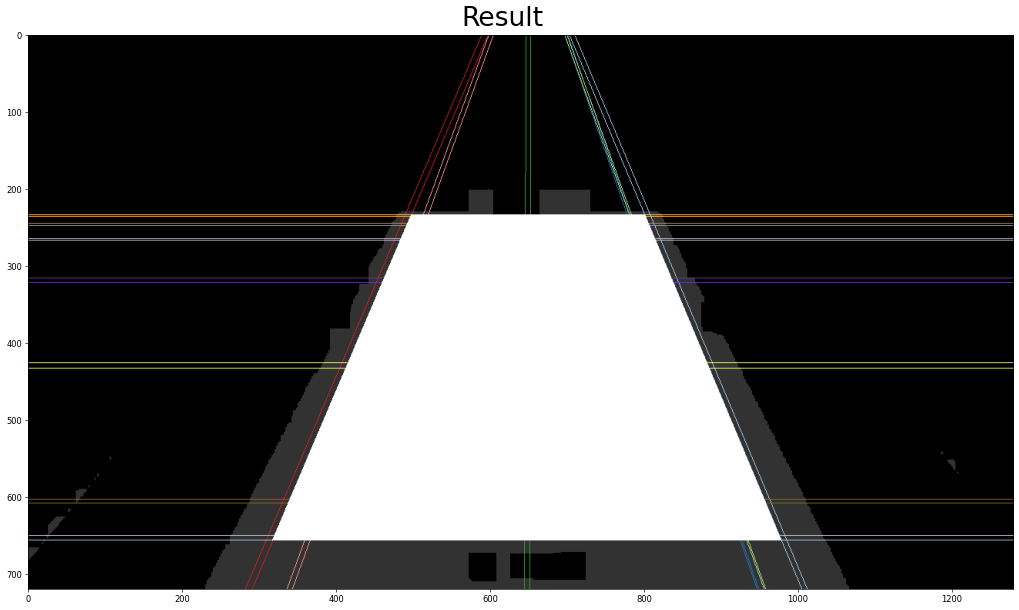

In [740]:
import itertools

# choose1 = list(itertools.combinations(SET1, 2))
# choose2 = list(itertools.combinations(SET2, 2))
# pp.pprint(choose1)
# pp.pprint(choose2)

# print(set([(i[0], i[-1]) for i in choose1]))
# print(set([(i[0], i[-1]) for i in choose2]))

# print(list(itertools.combinations(SET1, 2)))

cand = 0
maxwin = 0
for l1, l2 in list(itertools.combinations(h_lines, 2)):
    for l3 in left_v_lines:
        for l4 in right_v_lines:
            p1 = np.array(find_intersection(lines[l1], lines[l3]))
            p2 = np.array(find_intersection(lines[l2], lines[l3]))
            p3 = np.array(find_intersection(lines[l2], lines[l4]))
            p4 = np.array(find_intersection(lines[l1], lines[l4]))
            pts = np.array([[p1, p2, p3, p4]]).astype("int32")
            test = np.copy(tmp_2_f)
            color = (255, 255, 255)
            test = cv2.fillPoly(test, pts, color)
            cv2.imwrite(folder + "cand_{}.png".format(cand), test)
            cand += 1
            test = np.zeros((_h, _w), "uint8")
            test = cv2.fillPoly(test, pts, (1, 1, 1)).astype(bool)
            if (
                np.logical_and(mask[..., 0], test).sum() > maxwin
                and np.logical_and(mask[..., 0], test).sum() * 100 / test.sum() > 80
            ):
                print("new winner:")
                maxwin = np.logical_and(mask[..., 0], test).sum()
                best = ((l1, l2), (l3, l4))
            print(
                "{} {} count {}/{}, {:.2f}, {}".format(
                    (l1, l2),
                    (l3, l4),
                    np.logical_and(mask[..., 0], test).sum(),
                    test.sum(),
                    np.logical_and(mask[..., 0], test).sum() * 100 / test.sum(),
                    ""
                    if np.logical_and(mask[..., 0], test).sum() * 100 / test.sum() < 80
                    else "good",
                )
            )
#         cv2.imshow('test', test.astype('uint8')*255)
#         cv2.waitKey(0)
cv2.destroyAllWindows()

((l1, l2), (l3, l4)) = best
p1 = np.array(find_intersection(fake_sets[l1][0], fake_sets[l3][0]))
p2 = np.array(find_intersection(fake_sets[l2][1], fake_sets[l3][0]))
p3 = np.array(find_intersection(fake_sets[l2][1], fake_sets[l4][1]))
p4 = np.array(find_intersection(fake_sets[l1][0], fake_sets[l4][1]))
pts = np.array([[p1, p2, p3, p4]]).astype("int32")
test = np.copy(tmp_2_f)
color = (255, 255, 255)
test = cv2.fillPoly(test, pts, color)
cv2.imwrite(folder + "court_result.png", test)


fig = plt.figure(figsize=(24, 12), dpi=60)
fig.suptitle("Result", y=0.92, fontsize=32)

plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()

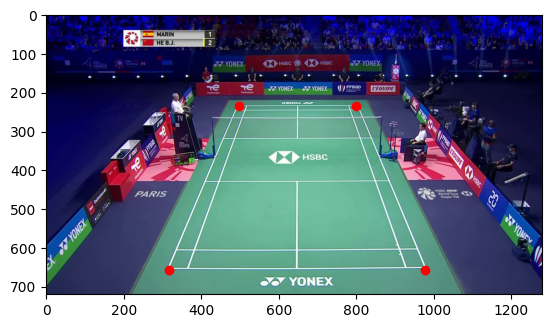

In [741]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.plot(p1[0], p4[1], marker="o", color="red")  # upper-right
plt.plot(p3[0], p2[1], marker="o", color="red")  # lower-left
plt.plot(p4[0], p1[1], marker="o", color="red")  # upper-left
plt.plot(p2[0], p3[1], marker="o", color="red")  # lower-right
plt.show()